In [1]:
import sys
import tensorflow as tf
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt
from skimage.util import montage as montage2d
from glob import glob
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [9]:
sys.path.append("..")
from spatial_transform.aff_mnist_data import IMAGE_SIZE, IMAGE_SHAPE, IMAGE_NUM_CHANNELS, get_aff_mnist_data
from spatial_transform.spatial_transforms import AffineTransform, QuadraticTransform
from spatial_transform.st_blocks import SimpleSpatialTransformBlock
from spatial_transform.localization import StandardConvolutionalLocalizationLayer, CoordConvLocalizationLayer, LargeLocalizationLayer
from spatial_transform.interpolation import BilinearInterpolator
from spatial_transform.layers import RepeatWithSharedWeights
from spatial_transform.visualization import show_train_progress

In [3]:
train_img_data, train_img_label, validation_img_data, validation_img_label, test_img_data, test_img_label = get_aff_mnist_data()

In [4]:
image = tf.keras.layers.Input(shape=IMAGE_SHAPE + (IMAGE_NUM_CHANNELS,))
size_after_transform = 28

spatial_transform = QuadraticTransform()
st_block = SimpleSpatialTransformBlock(
    localization_layer = LargeLocalizationLayer(
        spatial_transform_params_cls = spatial_transform.param_type,
        init_scale = 1,
    ),
    spatial_transform = spatial_transform,
    interpolator = BilinearInterpolator(),
    shape_out = (size_after_transform, size_after_transform)
)
stn_slx_chain = RepeatWithSharedWeights(layer=st_block, num_repetitions=3)

x = tf.image.resize(image, size=(size_after_transform,size_after_transform))
x = stn_slx_chain(x)
x = tf.keras.layers.Conv2D(16, [5, 5], activation='relu', padding="valid")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(16, [5, 5], activation='relu', padding="valid")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation=None)(x)

model = tf.keras.models.Model(inputs=image, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 1)]       0         
_________________________________________________________________
tf.image.resize (TFOpLambda) (None, 28, 28, 1)         0         
_________________________________________________________________
repeat_with_shared_weights ( (None, 28, 28, 1)         72590     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          6416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0     

In [5]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [6]:
history = model.fit(
    x = train_img_data, 
    y = train_img_label, 
    batch_size = 128,
    epochs = 20,
    validation_data = (test_img_data,  test_img_label),
    validation_batch_size = 1024,
)

Epoch 1/6
12500/12500 [==============================] - 602s 48ms/step - loss: 3.1656 - accuracy: 0.1968 - val_loss: 0.7198 - val_accuracy: 0.7666
Epoch 2/6
12500/12500 [==============================] - 584s 47ms/step - loss: 0.5858 - accuracy: 0.8133 - val_loss: 0.3681 - val_accuracy: 0.8853
Epoch 3/6
12500/12500 [==============================] - 570s 46ms/step - loss: 0.3141 - accuracy: 0.9022 - val_loss: 0.2350 - val_accuracy: 0.9266
Epoch 4/6
12500/12500 [==============================] - 570s 46ms/step - loss: 0.2288 - accuracy: 0.9292 - val_loss: 0.1833 - val_accuracy: 0.9427
Epoch 5/6
12500/12500 [==============================] - 570s 46ms/step - loss: 0.1868 - accuracy: 0.9424 - val_loss: 0.1551 - val_accuracy: 0.9518
Epoch 6/6
12500/12500 [==============================] - 570s 46ms/step - loss: 0.1602 - accuracy: 0.9505 - val_loss: 0.1302 - val_accuracy: 0.9597


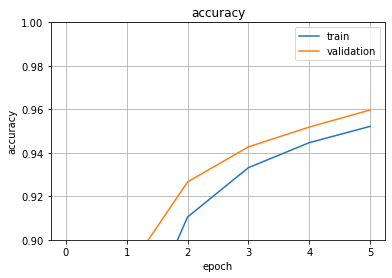

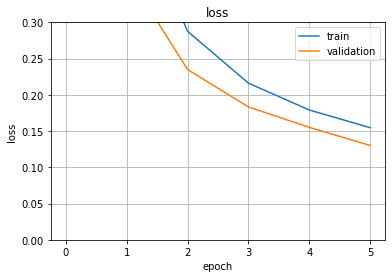

In [10]:
show_train_progress(history)

In [8]:
#model.save_weights("STN_quadratic_chain_backbone.h5")

### Investigate transformed features

In [11]:
images = tf.cast(tf.expand_dims(test_img_data[0:20], 3), dtype=tf.float32)
labels = test_img_label[0:20]

In [13]:
x = tf.image.resize(images, size=(size_after_transform,size_after_transform))
transformed_images = stn_slx_chain(x)

0


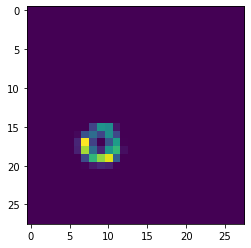

1


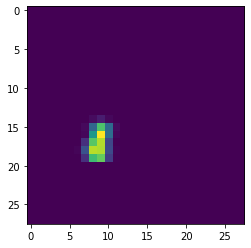

2


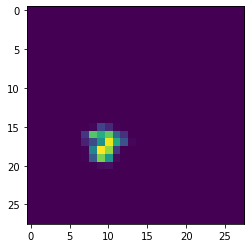

7


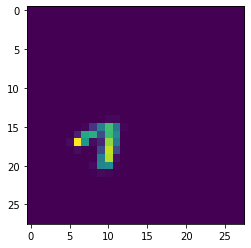

3


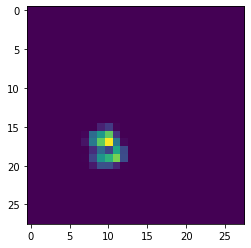

9


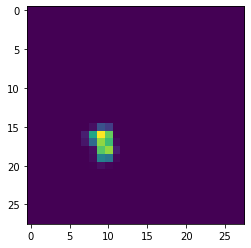

4


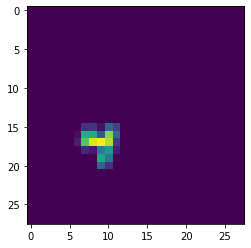

8


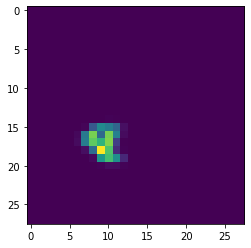

6


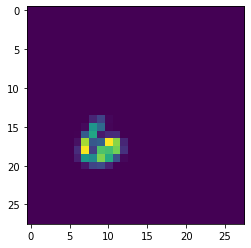

5


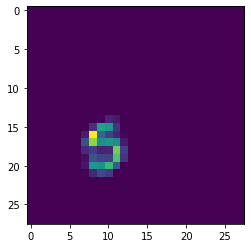

1


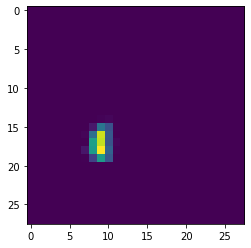

2


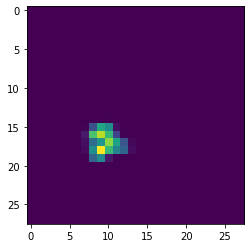

7


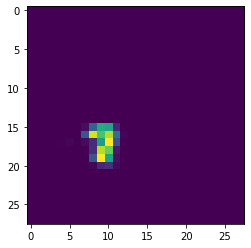

3


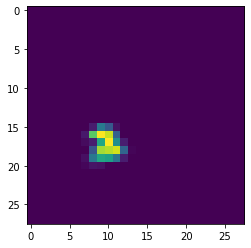

9


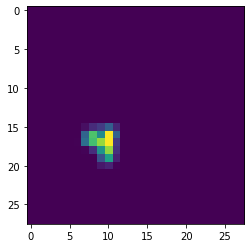

4


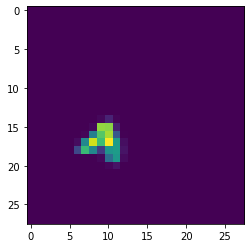

0


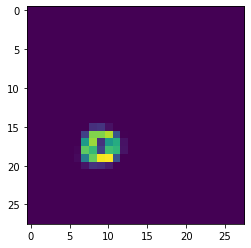

8


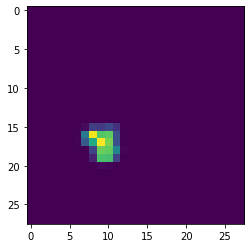

6


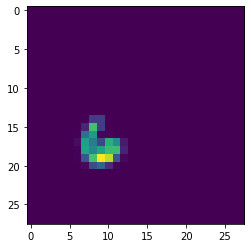

5


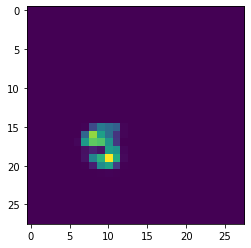

In [14]:
for image, label in zip(transformed_images, labels):
    print(label)
    plt.imshow(image.numpy()[:,:,0])
    plt.show()
